In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

In [ ]:
%ls ./data/processed

# T1H-X1700M-Y1760M/  T24H-X850M-Y880M/  T3H-X850M-Y880M/
# T12H-X850M-Y880M/  T24H-X425M-Y440M/   T24H-X85M-Y110M/   T6H-X850M-Y880M/

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from utils.mock_data import mock_data
from utils.plots import im

In [75]:
data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "FNN-CRIME-MODEL"  # needs to be created

data_path = f"./data/processed/{data_dim_str}/"
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.2,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-10-22T19:57:06 | root | INFO | =====================================BEGIN=====================================
2019-10-22T19:57:06 | root | INFO | Device: cpu


In [89]:
log.getLogger().setLevel("WARNING")

In [77]:
class KangFeedForwardNetwork(nn.Module):
    def __init__(self, spc_size=37, tmp_size=15, env_size=512, dropout_p=0.5, model_arch=None):
        super(KangFeedForwardNetwork, self).__init__()

        # drop out is not saved on the model state_dict - remember to turn off in evaluation
        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(p=self.dropout_p)

        if model_arch:
            scp_net_h0 = model_arch.get("scp_net_h0")
            scp_net_h1 = model_arch.get("scp_net_h1")
            tmp_net_h0 = model_arch.get("tmp_net_h0")
            tmp_net_h1 = model_arch.get("tmp_net_h1")
            env_net_h0 = model_arch.get("env_net_h0")
            env_net_h1 = model_arch.get("env_net_h1")
            
            final_net_h0 = scp_net_h1 + tmp_net_h1 + env_net_h1
            final_net_h1 = model_arch.get("final_net_h1")
        else:  # default architechture
            scp_net_h0 = 256
            scp_net_h1 = 128
            tmp_net_h0 = 256
            tmp_net_h1 = 128
            env_net_h0 = 256
            env_net_h1 = 128

            final_net_h0 = scp_net_h1 + tmp_net_h1 + env_net_h1
            final_net_h1 = 1024

        self.spcNet = nn.Sequential(nn.Linear(spc_size, scp_net_h0),
                                    nn.ReLU(),
                                    nn.Linear(scp_net_h0, scp_net_h0),
                                    nn.ReLU(),
                                    nn.Linear(scp_net_h0, scp_net_h1),
                                    nn.ReLU())
        self.tmpNet = nn.Sequential(nn.Linear(tmp_size, tmp_net_h0),
                                    nn.ReLU(), nn.Linear(tmp_net_h0, tmp_net_h0),
                                    nn.ReLU(),
                                    nn.Linear(tmp_net_h0, tmp_net_h1),
                                    nn.ReLU())

        self.envNet = nn.Sequential(nn.Linear(env_size, env_net_h0),
                                    nn.ReLU(),
                                    nn.Linear(env_net_h0, env_net_h0),
                                    nn.ReLU(),
                                    nn.Linear(env_net_h0, env_net_h1),
                                    nn.ReLU())

        self.finalNet = nn.Sequential(nn.Linear(final_net_h0, final_net_h1),
                                      nn.ReLU(),
                                      nn.Linear(final_net_h1, final_net_h1),
                                      nn.ReLU(),
                                      nn.Linear(final_net_h1, 2))

    def forward(self, spc_vec, tmp_vec, env_vec):
        if self.dropout_p > 0:
            spc_vec = self.dropout(spc_vec)
            tmp_vec = self.dropout(tmp_vec)
            env_vec = self.dropout(env_vec)

        mid_vec = torch.cat([self.spcNet(spc_vec), self.tmpNet(tmp_vec), self.envNet(env_vec)], dim=-1)
        out_vec = self.finalNet(mid_vec)

        return out_vec  
    
class SmallKangFNN(nn.Module):  
    def __init__(self, spc_size=37, tmp_size=15, env_size=512, dropout_p=0.5, model_arch=None):
        super(SmallKangFNN, self).__init__()

        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(p=self.dropout_p)
        
        if model_arch:
            h_size0 = model_arch.get("h_size0")
            h_size1 = model_arch.get("h_size1")
            h_size2 = model_arch.get("h_size2")
        else:
            h_size0 = 50
            h_size1 = 50
            h_size2 = 50


        self.spcNet = nn.Sequential(nn.Linear(spc_size, h_size0),
                                    nn.ReLU(), 
                                    nn.Linear(h_size0, h_size1), 
                                    nn.ReLU())
        self.tmpNet = nn.Sequential(nn.Linear(tmp_size, h_size0), 
                                    nn.Linear(h_size0, h_size1), 
                                    nn.ReLU())
        
        self.envNet = nn.Sequential(nn.Linear(env_size, h_size0), 
                                    nn.ReLU(),
                                    nn.Linear(h_size0, h_size1), 
                                    nn.ReLU())
        
        self.finalNet = nn.Sequential(nn.Linear(3*h_size1, h_size2), 
                                      nn.ReLU(),
                                      nn.Linear(h_size2, 2))

    def forward(self, spc_vec, tmp_vec, env_vec):
        if self.dropout_p > 0:
            spc_vec = self.dropout(spc_vec)
            tmp_vec = self.dropout(tmp_vec)
            env_vec = self.dropout(env_vec)

        mid_vec = torch.cat([self.spcNet(spc_vec), self.tmpNet(tmp_vec), self.envNet(env_vec)], dim=-1)
        out_vec = self.finalNet(mid_vec)

        return out_vec      

In [78]:
from utils.preprocessing import Shaper

class MockLoaders:
    def __init__(self, train_loader=None, validation_loader=None, test_loader=None):
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader
    
    
class MockLoader:
    def __init__(self, vector_size, batch_size, n_samples, class_split):
        n_feats = np.sum(vector_size)
        X, y = mock_data(n_samples=n_samples, n_feats=n_feats, class_split=class_split)
      
        y = np.expand_dims(y, axis=1)
        y = np.expand_dims(y, axis=0)
        
        #(N,C,L) in the dataset but (seq_len, batch_size, n_features) in loader
        self.targets = np.copy(y).swapaxes(0,1) # format is now in (N,C,L)
        self.t_range = pd.date_range(start='2012',end='2016', periods=n_samples)
        self.shaper = None
        X = np.expand_dims(X, axis=0)
        
        self.indices = np.array([(i,0,0) for i in np.arange(n_samples)]) # (N,C,L) format
        
        vectors = []
        i = 0
        for j in vector_size:
            vectors.append(X[:,:,i:i+j])
            i += j
        vectors.append(y)    
        
        self.n_samples = n_samples
        self.n_feats = n_feats
        self.vectors = vectors
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(self.n_samples / self.batch_size))
        self.current_batch = 0
        
        self.max_index = n_samples
        self.min_index = 0
        self.dataset = self # just to act as an interface
   
    def __len__(self):
        return self.n_samples

    def __iter__(self):
        self.current_batch = 0
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        else:
            self.current_batch += 1
            start_index = (self.current_batch - 1) * self.batch_size
            stop_index = self.current_batch * self.batch_size
            if stop_index > len(self):
                stop_index = len(self)
            return self[start_index:stop_index]
        
            
    def __getitem__(self, index):
        r = tuple(map(lambda x: x[:,index], self.vectors))
        return (self.indices[index], *r)

In [79]:
# generic training loop
def train_model(model, optimiser, loaders, train_epoch_fn, loss_fn, conf):
    """
    Generic training loop that handles:
    - early stopping
    - timing
    - logging
    - model checkpoints
    - saving epoch and batch losses
    
    :returns: best validation loss of all the epochs - used to tune the hyper-parameters of the models/optimiser
    """
    stopped_early = False
    trn_batch_losses = []
    val_batch_losses = []

    trn_epoch_losses = []
    val_epoch_losses = []
    val_epoch_losses_best = float("inf")
    
    if conf.resume:
        try:
            # load losses
            losses_zip = np.load(f"{conf.model_path}losses_{conf.checkpoint}.npz")

            val_batch_losses = losses_zip["val_batch_losses"].tolist()
            trn_batch_losses = losses_zip["trn_batch_losses"].tolist()

            trn_epoch_losses = losses_zip["trn_epoch_losses"].tolist()
            val_epoch_losses = losses_zip["val_epoch_losses"].tolist() 
            val_epoch_losses_best = float(losses_zip["val_epoch_losses_best"])  
        except Exception as e:
            log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

    log.info(f"Start Training {conf.model_name}")
    log.info(f"Using optimiser: \n{optimiser}\n\n")
    
    for epoch in range(conf.max_epochs):
        log.info(f"Epoch: {(1+epoch):04d}/{conf.max_epochs:04d}")
        conf.timer.reset()
        # Training loop
        model.train()
        epoch_loss = train_epoch_fn(model=model, 
                                    optimiser=optimiser, 
                                    batch_loader=loaders.train_loader, 
                                    loss_fn=loss_fn,
                                    total_losses=trn_batch_losses, 
                                    conf=conf)

        trn_epoch_losses.append(epoch_loss)
        log.debug(f"Epoch {epoch} -> Training Loop Duration: {conf.timer.check()}")
        conf.timer.reset()

        # Validation loop
        tmp_val_epoch_losses = []
        with torch.set_grad_enabled(False):
            model.eval()
            epoch_loss = train_epoch_fn(model=model, 
                                        optimiser=optimiser, 
                                        batch_loader=loaders.validation_loader,
                                        loss_fn=loss_fn,
                                        total_losses=val_batch_losses, 
                                        conf=conf)

            val_epoch_losses.append(epoch_loss)
            log.debug(f"Epoch {epoch} -> Validation Loop Duration: {conf.timer.check()}")

        log.info(f"\tLoss (Trn): \t{trn_epoch_losses[-1]:.5f}")
        log.info(f"\tLoss (Val): \t{val_epoch_losses[-1]:.5f}")
        log.info(f"\tLoss (Dif): \t{np.abs(val_epoch_losses[-1]-trn_epoch_losses[-1]):.5f}\n")        

        # save best model
        if val_epoch_losses[-1] < val_epoch_losses_best:
            val_epoch_losses_best = val_epoch_losses[-1]
            torch.save(model.state_dict(),  f"{conf.model_path}model_best.pth")
            torch.save(optimiser.state_dict(), f"{conf.model_path}optimiser_best.pth")
            np.savez_compressed(file=f"{conf.model_path}losses_best.npz",
                                val_batch_losses=val_batch_losses,
                                val_epoch_losses=val_epoch_losses,
                                trn_epoch_losses=trn_epoch_losses,
                                trn_batch_losses=trn_batch_losses,
                                val_epoch_losses_best=val_epoch_losses_best)

        # increasing moving average of val_epoch_losses
        if conf.early_stopping and epoch > 5 and np.sum(np.diff(val_epoch_losses[-5:])) > 0:
            log.warning("Early stopping: Over-fitting has taken place")
            stopped_early = True
            break

        if conf.early_stopping and epoch > 5 and np.abs(val_epoch_losses[-1]-val_epoch_losses[-2]) < conf.tolerance:
            log.warning(f"Converged: Difference between the past two" 
                        + f" validation losses is within tolerance of {conf.tolerance}")
            stopped_early = True
            break

        # checkpoint - save models and loss values
        torch.save(model.state_dict(), f"{conf.model_path}model_latest.pth")
        torch.save(optimiser.state_dict(), f"{conf.model_path}optimiser_latest.pth")
        np.savez_compressed(file=f"{conf.model_path}losses_latest.npz",
                            val_batch_losses=val_batch_losses,
                            val_epoch_losses=val_epoch_losses,
                            trn_epoch_losses=trn_epoch_losses,
                            trn_batch_losses=trn_batch_losses,
                            val_epoch_losses_best=val_epoch_losses_best)
    
    # Save training and validation plots - add flag to actually save or display
    skip = 0
    loss_plotter = LossPlotter(title=f"Cross Entropy Loss ({conf.model_name})")
    loss_plotter.plot_losses(trn_epoch_losses, trn_batch_losses[skip:], val_epoch_losses, val_batch_losses[skip:])
    loss_plotter.savefig(f"{conf.model_path}plot_train_val_epoch_losses.png")    
    
    return val_epoch_losses_best, stopped_early

In [80]:
log.getLogger().setLevel("WARNING")

In [81]:
# epoch_loop - wrapper with checkpoint saving and logging
# tmp is only per epoch. all is for all epoch
# train_loop - use conf to get device?
def train_epoch_for_fnn(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    """
    Training the model for a single epoch
    """
    epoch_losses = []
    num_batches = batch_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
        current_batch = batch_loader.current_batch

        # Transfer to PyTorch Tensor and GPU
        spc_feats = torch.Tensor(spc_feats[0]).to(conf.device) # only taking [0] for fnn
        tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device) # only taking [0] for fnn
        env_feats = torch.Tensor(env_feats[0]).to(conf.device) # only taking [0] for fnn
        targets = torch.LongTensor(targets[0,:,0]).to(conf.device) # only taking [0] for fnn
            
        out = model(spc_feats, tmp_feats, env_feats)
        loss = loss_fn(input=out, target=targets)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])

        if model.training:  # not used in validation loops
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
    mean_epoch_loss = np.mean(epoch_losses)
    return mean_epoch_loss  

In [93]:
# CRIME DATA
conf.seq_len = 10
data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)
for indices, spc_feats, tmp_feats, env_feats, targets in loaders.train_loader:
    for i in [indices, spc_feats, tmp_feats, env_feats, targets]:
        print(np.shape(i))
    break

shape crimes_train ->  (256, 1, 763)
shape crimes ->  (364, 1, 763)
(64, 3)
(1, 64, 37)
(10, 64, 65)
(1, 64, 512)
(10, 64, 1)


2019-10-23T09:20:18 | root | INFO | Data shapes of files in generated_data.npz
2019-10-23T09:20:18 | root | INFO | 	crime_feature_indices shape (11,)
2019-10-23T09:20:18 | root | INFO | 	crime_types_grids shape (365, 11, 47, 33)
2019-10-23T09:20:18 | root | INFO | 	crime_grids shape (365, 1, 47, 33)
2019-10-23T09:20:18 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-10-23T09:20:18 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-10-23T09:20:18 | root | INFO | 	time_vectors shape (366, 52)
2019-10-23T09:20:18 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-23T09:20:18 | root | INFO | 	x_range shape (33,)
2019-10-23T09:20:18 | root | INFO | 	y_range shape (47,)
2019-10-23T09:20:18 | root | INFO | 	t_range shape (366,)
shape crimes_train ->  (256, 1, 763)
shape crimes ->  (364, 1, 763)
2019-10-23T09:20:18 | root | INFO | Start Training FNN-CRIME-MODEL
2019-10-23T09:20:18 | root | INFO | Using optimiser: 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 

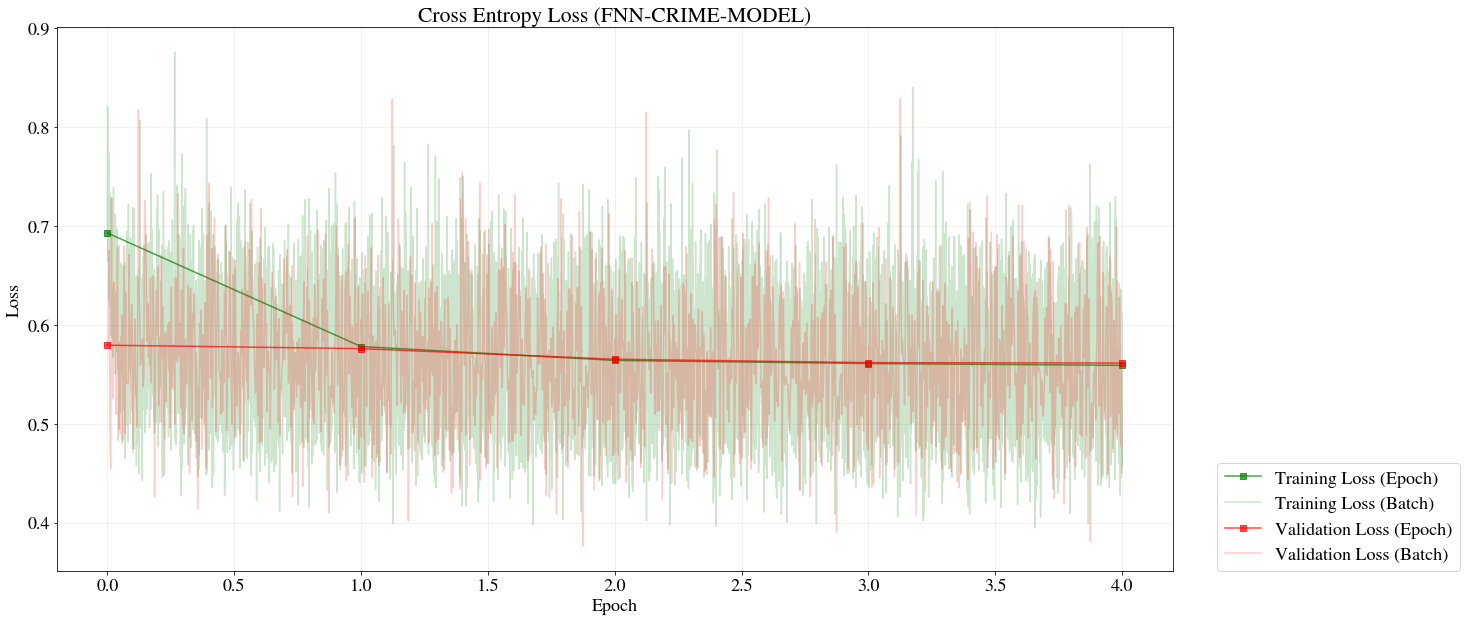

In [88]:
# SET THE HYPER PARAMETERS
conf.early_stopping = False
conf.max_epochs = 4
conf.dropout = 0 #1e-3
conf.weight_decay = 0
conf.resume = False
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 1e-2
conf.shaper_top_k = -1

MOCK = False

if MOCK:
    # MOCK THE DATA
    vector_size= [5,5,5]#[37,65,512]
    batch_size = 100    
    class_split=0.5
    train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
    validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
    test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
    loaders = MockLoaders(train_loader,validation_loader,test_loader)
else:
    # CRIME DATA
    data_group = FlatDataGroup(data_path=data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)


# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.CrossEntropyLoss()  

# SETUP MODEL
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


model_arch = {
    "h_size0": 100,
    "h_size1": 100,
    "h_size2": 100,
}
model = SmallKangFNN(spc_size=spc_size,
                     tmp_size=tmp_size,
                     env_size=env_size,
                     dropout_p=conf.dropout,
                     model_arch=model_arch)

# model_arch = {
#     "scp_net_h0": 64,
#     "scp_net_h1": 32,
#     "tmp_net_h0": 64,
#     "tmp_net_h1": 32,
#     "env_net_h0": 64,
#     "env_net_h1": 32,
#     "final_net_h1": 64,
# }
# model = KangFeedForwardNetwork(spc_size=spc_size,
#                                  tmp_size=tmp_size,
#                                  env_size=env_size,
#                                  dropout_p=conf.dropout,
#                                  model_arch=model_arch)

model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

best_val_loss, stopped_early = train_model(model=model,
                                            optimiser=optimiser,
                                            loaders=loaders,
                                            train_epoch_fn=train_epoch_for_fnn,
                                            loss_fn=loss_function,
                                            conf=conf)    


print(f"best_val_loss: {best_val_loss}, stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [83]:
log.getLogger().setLevel("INFO")

# Evaluation

2019-10-23T09:18:58 | root | INFO | f1_score: 0.6694275994675345 at index 13753, new threshold 0.3914801776409149
2019-10-23T09:18:58 | root | INFO | 
        MODEL METRICS
            Model Name: FNN-CRIME-MODEL
                ROC AUC:            0.7764347214241627
                Average Precision:  0.6924961769438922
                Accuracy:           0.6789888507872672
                MCC:                0.3945497131275264          
        
2019-10-23T09:18:58 | root | INFO | 
        MODEL RESULT
            Model Name: FNN-CRIME-MODEL
                ROC AUC:            0.7764347214241627
                Average Precision:  0.6924961769438922
                Accuracy:           0.6789888507872672
                MCC:                0.3945497131275264          
        


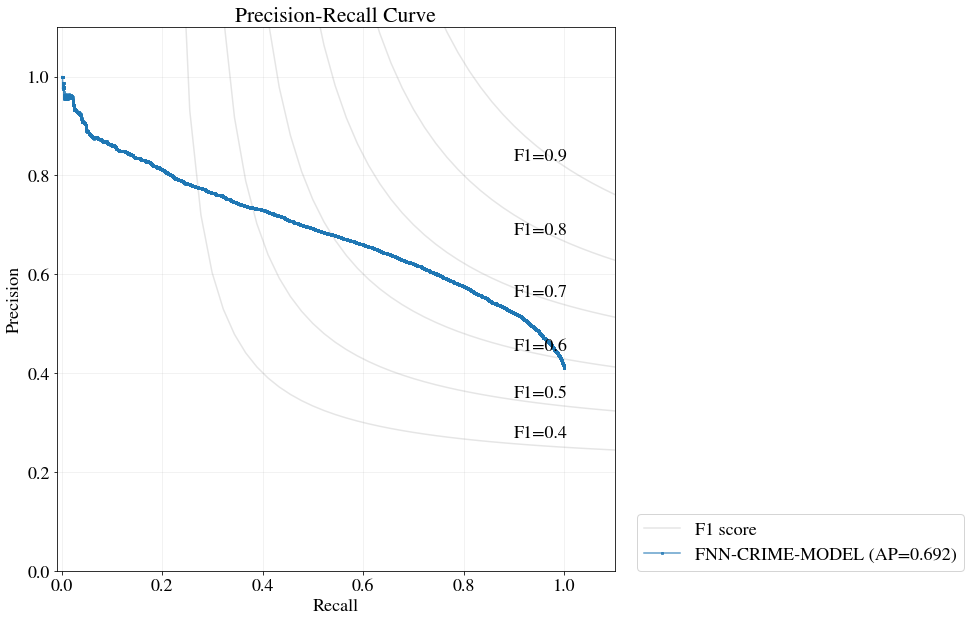

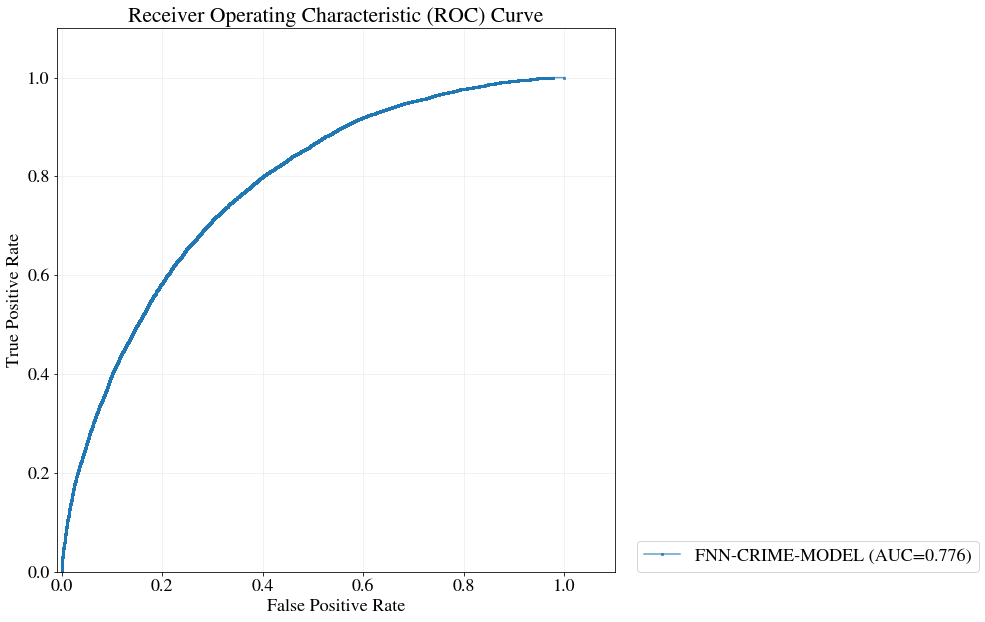

In [87]:
from utils.metrics import best_threshold

# todo make wrapper that takes eval loop which returns probas_pred
def eval_fn_fnn(model, batch_loader, conf):

    # NOTE: important when using zeros_like, specify dtype - else float values are truncated to 0
    probas_pred = np.zeros_like(batch_loader.dataset.targets,dtype=np.float)
    y_true = np.zeros_like(batch_loader.dataset.targets,dtype=np.float)
    
    with torch.set_grad_enabled(False):
        model.eval()
            
        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch

            # Transfer to PyTorch Tensor and GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(conf.device) # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device) # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(conf.device) # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(conf.device) # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            batch_probas_pred = F.softmax(out,dim=-1)[:,1].numpy() # select class1 prediction
            
            for i, p, t in zip(indices,batch_probas_pred, targets.numpy()):
                n,c,l = i
                y_true[n,c,l] = t   
                probas_pred[n,c,l] = p

    y_pred = np.copy(probas_pred)
    thresh = best_threshold(y_true, probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0
    
    return y_true, y_pred, probas_pred

def evaluate_model(model, batch_loader, eval_fn, shaper, conf):
    """
    Training the model for a single epoch
    """
    y_true, y_pred, probas_pred = eval_fn(model, batch_loader, conf)
 
    # save result
    # only saves the restult of the metrics not the predicted values
    model_metrics = ModelMetrics(model_name=conf.model_name,
                                 y_true=y_true,
                                 y_pred=y_pred,
                                 probas_pred=probas_pred)
    log.info(model_metrics)
    
    # saves the actaul target and predicted values to be visualised later on
    model_result = ModelResult(model_name=conf.model_name,
                                y_true=y_true,
                                y_pred=y_pred,
                                probas_pred=probas_pred,
                                t_range=batch_loader.dataset.t_range,
                                shaper=shaper)
    log.info(model_result)
    
    # do result plotting and saving 
    pr_plotter = PRCurvePlotter()
    pr_plotter.add_curve(y_true.flatten(), probas_pred.flatten(), label_name=conf.model_name)
    pr_plotter.savefig(model_path + "plot_pr_curve.png")

    roc_plotter = ROCCurvePlotter()
    roc_plotter.add_curve(y_true.flatten(), probas_pred.flatten(), label_name=conf.model_name)
    roc_plotter.savefig(model_path + "plot_roc_curve.png")
    return y_true, y_pred, probas_pred

y_true, y_pred, probas_pred = evaluate_model(model=model,
                       batch_loader=loaders.test_loader,
                       eval_fn=eval_fn_fnn,
                       shaper=None,#data_group.shaper,
                       conf=conf)

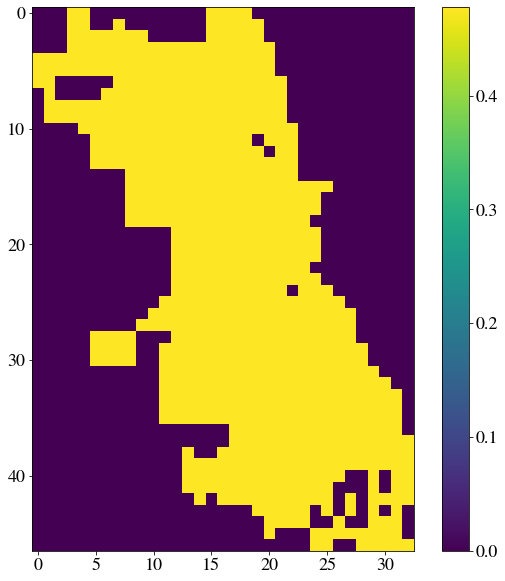

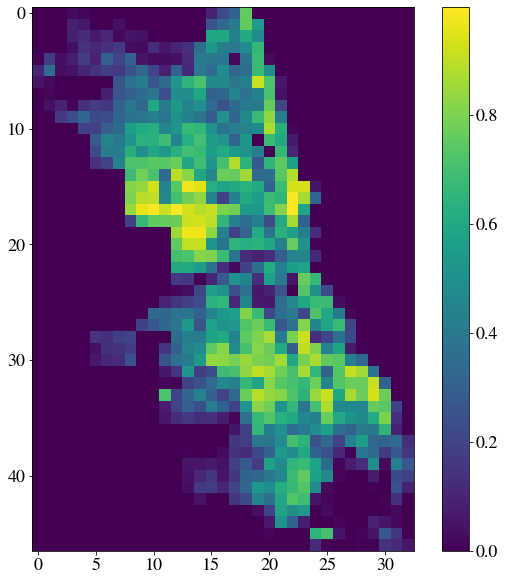

In [86]:
im(data_group.shaper.unsqueeze(probas_pred).mean(0)[0])
im(data_group.shaper.unsqueeze(data_group.targets).mean(0)[0])

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

In [ ]:
roc_auc_score()

In [ ]:
def average_precision_score_per_cell(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(L)
    
    for i in range(L):
        result[i] = average_precision_score(y_true=y_true[:,:,i].flatten()
                                            , y_score=probas_pred[:,:,i].flatten())
        
    return result

def roc_auc_score_per_cell(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(L)
    
    for i in range(L):
        result[i] = average_precision_score(y_true=y_true[:,:,i].flatten(),
                                            y_score=probas_pred[:,:,i].flatten())
        
    return result
    
    
def average_precision_score_per_time_slot(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(N)
    
    for i in range(N):
        result[i] = average_precision_score(y_true=y_true[:,:,i].flatten(),
                                            y_score=probas_pred[:,:,i].flatten())
        
    return result

def roc_auc_score_per_time_slot(y_true, probas_pred):
    """
    y_true: shape (N,1,L)
    probas_pred: (N,1,L)
    """
    N,_,L = y_true.shape
    result = np.zeros(N)
    
    for i in range(N):
        result[i] = average_precision_score(y_true=y_true[i,:,:].flatten(),
                                            y_score=probas_pred[i,:,:].flatten())
        
    return result    
    

# metric_per_time_step - get the auc or ap 

In [ ]:
im(data_group.shaper.unsqueeze(probas_pred)[40][0])
im(data_group.shaper.unsqueeze(loaders.test_loader.dataset.targets)[40][0])

In [ ]:
loaders.test_loader.dataset.targets.shape

# Todo Evaluation prediction formating into an actual map

In [ ]:
targets = loaders.data_group.testing_set.targets

# todo get better name
probas_grid = np.zeros_like(targets)

In [ ]:

###### testing ###### torch outputs to see if we're actually getting valuable things out
out = torch.Tensor([[-3,2],[2,-1],[0.5,0.4]])
print(out.shape)
print(out)
out_soft = F.softmax(out, dim=-1)
print(out_soft)
out_label = torch.argmax(out_soft, dim=-1)
print(out_label)



In [ ]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
conf.batch_size = 4
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    
    # loop through is set does not fit in batch
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.test_loader: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(conf.device)
        tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
        env_feats = torch.Tensor(env_feats).to(conf.device)
        targets = torch.LongTensor(targets).to(conf.device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
        
        
        
        out = F.softmax(out, dim=-1)
        
        log.info(f"out: {out}")
        log.info(f"indices: {indices}")
        log.info(f"indices: {targets}")
    
        out_label = torch.argmax(out, dim=-1)
        log.info(f"out_label: {out_label}")
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())
        
        break  # !! remove


# todo change to be the shape (N,L) of the original prediction.        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.test_loader.dataset.t_range,
                            shaper=loaders.data_group.shaper)
                        
# log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)

In [ ]:
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")targets.shape